In [7]:
import geopandas as gpd

import json
from shapely.geometry import shape, Point
import seaborn as sns
import numpy as np
import sympy as sp
import pandas as pd
from math import cos, asin, sqrt
import matplotlib.pyplot as plt
import random
import math
import sys
import copy
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Function to map tabular data to speed using distance between points
def RealSpeed(d,t):
    try:
        return float(d/t*3600.)
    except:
        return None

# Euclidean distance
def distance(lat1, lon1 ,lat2 , lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...  

sns.set()
sns.set_palette("BuGn_r")


In [8]:
def WriteRoute(Next,init,route):
    route.append(init)
    if Next[init] in Next.keys():
        
        return WriteRoute(Next,Next[init],route)
    else:
        return route

In [9]:
class MyNode:
    def __init__(self):
        self.ID_patient=None
        self.ID_node=None
        self.st_time=None
        self.serv_time=None
        self.type_serv=None
        self.in_neighbors=[]
        self.out_neighbors=[]

    def imprimir(self):
        print("Patient ID:",self.ID_patient)
        print("st time:",self.st_time)
        print("serv time:",self.serv_time)
        print("Follow:",self.in_neighbors)
        print("Coming:",self.out_neighbors)
        print("Node ID:",self.ID_node)
    
    def imprimirLineal(self):
         print(self.ID_patient,self.st_time/3600,self.serv_time/3600)

In [4]:
def FindMiddlePoints(mus,T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols('tau_0:24')
    t=sp.Symbol('t')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    results=[int(i) for i in results]
    return results

In [10]:
def FindMiddlePointsSymbol(T,draw=False):
    a=np.array([(1/2.*n) for n in range(2*T+1)])
    tau=sp.symbols(str('tau_0:')+str(T))
    t=sp.Symbol('t')
    mus=sp.symbols('u_0:24')
    E=[]
    for N in range(0,T):
        if N>0 and N<T-1:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        elif N==0:
            y1=((tau[N]-tau[T-1]))/(a[2*N+1]-(-a[2*N+1]))*(t-(-a[2*N+1]))+tau[T-1]
            y2=((tau[N+1]-tau[N]))/(a[2*N+3]-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)        
        else:
            y1=((tau[N]-tau[N-1]))/(a[2*N+1]-a[2*N-1])*(t-a[2*N-1])+tau[N-1]
            y2=((tau[0]-tau[N]))/(a[2*N+1]+1-a[2*N+1])*(t-a[2*N+1])+tau[N]
            eq1=sp.integrate(y1,(t,a[2*N],a[2*N+1]))
            eq2=sp.integrate(y2,(t,a[2*N+1],a[2*N+2]))
            e=eq1+eq2-mus[N]
            E.append(e)
            #print(e)
        

    salida=sp.linsolve(E, (tau))
    #print(salida)
    results=next(iter(salida))
    
    
    if draw:
        plt.figure(figsize=(10, 5))
        plt.bar([0.5+i for i in range(T)], mus, label="Predicted hourly travel time", width=0.95, align='center',color='lightgray')
        plt.plot([0.5+i for i in range(T)],results,label="Interpolation")
        plt.xlabel('Hour')
        plt.ylabel(r'Travel Time (s)')
        plt.legend(prop={'size': 8})
        plt.savefig('./Images/Middle_points_reg.pdf')
        plt.show()
    
    #results=[int(i) for i in results]
    return results



In [11]:
mus=FindMiddlePointsSymbol(24,False)
u=sp.symbols('u_0:24')
mus[0].subs([(u[i],10*i) for i in range(24)])

-49.7056245218898

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


33.47520000560799


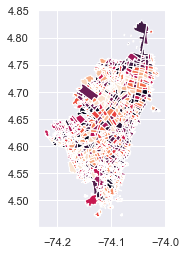

In [12]:
filename="./Input_Data/output_distances_22_8_18_1.csv"#sys.argv[1]

    
    
datos=pd.DataFrame(pd.read_csv("./Input_Data/bogota-cadastral-2019-3-OnlyWeekdays-HourlyAggregate.csv"))
#~ datos=pd.concat([datos1,datos2],keys=['2017-4', '2018-1'])
#print(datos)

dictDistances=pd.DataFrame(pd.read_csv(filename,header=None))
dictDistances=dictDistances.to_dict()

print(dictDistances[1][2])

data=gpd.read_file('./Input_Data/bogota_geo.json')
    
with open('./Input_Data/limites_geojson.json') as f:
	data_lims = json.load(f)   

data=data[data.scatipo.eq(0)]

data.plot(column='cartodb_id')
plt.savefig('world.pdf')


localidades=gpd.read_file('./Input_Data/Bog-poligonos-localidades.geojson')

In [13]:
posx={}
posy={}
for index, row in data.iterrows():
    try:
        posx[row['cartodb_id']],posy[row['cartodb_id']]=shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0]
    except:
        #print(row['cartodb_id'])
        pass
    #print(shape(row['geometry']).representative_point().xy[0][0],shape(row['geometry']).representative_point().xy[1][0])

TopologyException: Input geom 1 is invalid: Self-intersection at or near point -74.093562714285724 4.5682967142857134 at -74.093562714285724 4.5682967142857134
TopologyException: Input geom 1 is invalid: Self-intersection at or near point -74.093562714285724 4.5682967142857134 at -74.093562714285724 4.5682967142857134


In [14]:
# Adding new columns to the dataframe containg the travel times as read from Uber datafile.
datos["CoorXOrigen"]=datos["sourceid"].map(posx)
datos["CoorYOrigen"]=datos["sourceid"].map(posy)
datos["CoorXDestino"]=datos["dstid"].map(posx)
datos["CoorYDestino"]=datos["dstid"].map(posy)
datos=datos.dropna()

In [15]:
datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod, "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})

"""datos=pd.DataFrame(datos)
#print(datos.dtypes)
df=pd.DataFrame({"CoorXOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorXOrigen, "CoorYOrigen":datos.loc[datos.sourceid!=datos.dstid].CoorYOrigen, \
                "CoorXDestino":datos.loc[datos.sourceid!=datos.dstid].CoorXDestino, "CoorYDestino":datos.loc[datos.sourceid!=datos.dstid].CoorYDestino,\
               "horadeldia":datos.loc[datos.sourceid!=datos.dstid].hod,  , "tiempo_hora":datos.loc[datos.sourceid!=datos.dstid].mean_travel_time})"""

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

#df=pd.DataFrame({"CoorXOrigen":datos["CoorXOrigen"], "CoorYOrigen":datos["CoorYOrigen"], \
#                 "CoorXDestino":datos["CoorXDestino"], "CoorYDestino":datos["CoorYDestino"],\
#                "horadeldia":datos["hod"], "tiempo_hora":datos["mean_travel_time"]})

cols=["CoorXOrigen","CoorYOrigen","CoorXDestino", "CoorYDestino","horadeldia","tiempo_hora"]
df.reindex(cols)
display(df)

,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


,CoorXOrigen,CoorYOrigen,CoorXDestino,CoorYDestino,horadeldia,tiempo_hora
0,-74.099623,4.686262,-74.087588,4.721148,10,1282.33
3,-74.033439,4.684943,-74.214904,4.625836,13,2043.50
4,-74.111644,4.677749,-74.180046,4.589392,0,514.12
5,-74.091591,4.707669,-74.211202,4.611970,0,399.07
6,-74.068389,4.692584,-74.037335,4.680848,10,1763.42
...,...,...,...,...,...,...
7060937,-74.140316,4.543767,-74.118586,4.622618,15,1285.60
7060938,-74.109216,4.592483,-74.154047,4.543817,5,1766.67
7060939,-74.135737,4.656237,-74.155440,4.678437,5,2247.38
7060941,-74.135683,4.581468,-74.084660,4.722879,18,3551.04


In [16]:

# Using inverse distances, seven neighbors and Manhattan (p=1) distances
neigh = KNeighborsRegressor(n_neighbors=7, weights="distance", p=1) 
X = df.iloc[:, :-1].values  # Input
y = df.iloc[:,5].values #outout

# Normalizing the input data
scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)  

# "training" the model

neigh.fit(X, y)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                    weights='distance')

In [17]:
# A set of points to predict travel times during the whole day (Mandalay - Las aguas)

X_new=np.array([[-74.182690,  4.596858,-74.044301, 4.68261,   i] for i in range(24)])
X_new=scaler.transform(X_new)


#print predictions
print(neigh.predict(X_new))
#print(mus)
             
proms=neigh.predict(X_new)
#print(FindMiddlePoints(proms,24,True))

u=sp.symbols('u_0:24')
for t in range(24):
    print(mus[t].subs([(u[j],i) for i,j in zip(proms,range(24))]))


[ 694.68264382  684.57471118  713.60798607  867.39364897  860.79558555
 1192.22913552 1265.2196984  1495.90090228 1256.77587446 1201.35464937
 1136.74660164  917.70472523 1344.37328958 1136.77990075 1058.22006408
 1151.35033666 1648.09674403 2285.55067692 1756.56079671 1475.99345803
 1461.23939236 1108.52559266  873.88253654  935.69601789]
643.633724287963
691.437656951842
684.337685973449
911.400200742478
786.421798344422
1256.44188554244
1212.67024289685
1590.77390752663
1210.14585058405
1202.55802617577
1185.34322842275
779.355447875905
1480.16190599129
1094.65943307525
1046.12069952731
1094.37688182842
1598.42070275317
2499.87285393282
1686.74758903326
1432.12798552682
1528.43216204853
1087.19418107781
816.607492766946
1004.22115461406


In [18]:
Matriz=np.zeros(shape=(24,24))
#vector=np.array(neigh.predict(X_new))

#print(mus)
a = sp.Poly(mus[7], u[18])
#print(a.all_coeffs()[0])
#print(mus[18])
for i in range(24):
    for j in range(24):
        a = sp.Poly(mus[i], u[j])
        #print(i,j,a.all_coeffs()[0],)
        try:
            Matriz[i,j]=a.all_coeffs()[0]
        except:
            Matriz[i,j]=0

!pip install pulp
!pip install cbcpy

In [30]:
import pulp as plp
def RunModelPuLP(filename,Workers,constant=True,n_visits=3,):
    Coordenadas=pd.DataFrame(pd.read_csv(filename))
    Coordenadas=Coordenadas[["lon","lat","DUR","SERV","OPT1","OPT2","OPT3"]]
    #print(Coordenadas)

    dict_locaciones={}
    for iter,rows in Coordenadas.iterrows():
        for iter2,rows2 in Coordenadas.iterrows():
            if iter!=iter2:
                X_new=np.array([[rows["lon"],  rows["lat"],rows2["lon"],rows2["lat"],   i] for i in range(24)])
                X_new=scaler.transform(X_new)
                proms=np.array(neigh.predict(X_new))
                dict_locaciones[iter,iter2]=Matriz.dot(proms)

    horas=[(0.5+i)*3600 for i in range(24)]
    count_nodes=0
    dict_nodes={}
    edges={}
    Patient_nodes={}

    for iter,rows in Coordenadas.iterrows():
        listnodes=[]
        for node in range(n_visits):
            col_name="OPT"+str(node+1)
            count_nodes+=1
            x = MyNode()
            x.ID_patient=iter
            x.serv_time=rows["DUR"]
            x.ID_node=count_nodes
            x.st_time=rows[col_name]
            dict_nodes[x.ID_node]=x
            listnodes.append(x.ID_node)
        Patient_nodes[iter]=listnodes

    for i in dict_nodes.keys():
        for j in dict_nodes.keys():
            if i!=j and dict_nodes[i].ID_patient!=dict_nodes[j].ID_patient:
                if constant:
                    t=np.mean(dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient][8:20])
                else:
                    t=np.round(np.interp(dict_nodes[i].serv_time+dict_nodes[i].st_time, horas, dict_locaciones[dict_nodes[i].ID_patient,dict_nodes[j].ID_patient]),0)
                
                if dict_nodes[i].st_time+dict_nodes[i].serv_time+t<=dict_nodes[j].st_time:
                    dict_nodes[i].out_neighbors.append(dict_nodes[j].ID_node)
                    dict_nodes[j].in_neighbors.append(dict_nodes[i].ID_node)
                    edges[i,j]=t

    for i in range(1,count_nodes):
        edges[0,i]=0
        edges[i,count_nodes+1]=0

    SortedNodes=[]
    for i in np.sort(list(dict_nodes.keys())):
        SortedNodes.append(dict_nodes[i].st_time)

    SortedNodes=np.argsort(SortedNodes)+1
    
    Model = plp.LpProblem('netflow',plp.LpMaximize)
    x=plp.LpVariable.dicts("x",
                       edges.keys(),
                       0,
                       None,
                       cat=plp.LpBinary)
    y=plp.LpVariable.dicts("y",
                       Patient_nodes.keys(),
                       0,
                       None,
                       cat=plp.LpBinary)
    
    list_nodes=list(dict_nodes.keys())
    list_nodes+=[0,count_nodes+1]
    #print(list_nodes)
    #print(edges.keys())
    for c in dict_nodes.keys():
        Model+=plp.lpSum([x[(e[0],e[1])] for e in edges.keys() if e[0]==c])== plp.lpSum([x[(e[0],e[1])] for e in edges.keys() if e[1]==c]) 

    for j in Patient_nodes.keys():
        Model+=plp.lpSum([x[i,c] for i in list_nodes for c in Patient_nodes[j] if (i,c) in edges.keys()])==y[j]
    print(Patient_nodes.keys())
    Model+=plp.lpSum([x[0,j]  for j in dict_nodes.keys() if (0,j) in edges.keys() ])<=Workers, "Cobertura"
    
    Model+=plp.lpSum([y[j] for j in Patient_nodes.keys()])
    
    Model.solve()
    print("Mínimo Operarios = ",plp.value(Model.objective))

    while plp.value(Model.objective)<len(Coordenadas):
        Workers+=1
        Model.constraints["Cobertura"].changeRHS(Workers)
        Model.solve()
        print("Nivel de servicio = {}%".format(plp.value(Model.objective)/100))

RunModelPuLP("./new_Instances/HHC_100_1.csv",1,False)    

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Mínimo Operarios =  14.0
Nivel de servicio = 0.25%
Nivel de servicio = 0.35%
Nivel de servicio = 0.45%
Nivel de servicio = 0.55%
Nivel de servicio = 0.65%
Nivel de servicio = 0.74%
Nivel de servicio = 0.82%
Nivel de servicio = 0.88%
Nivel de servicio = 0.95%
Nivel de servicio = 1.0%
